In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

#Used for Google Colab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

#Read Data

In [3]:
# Dataset merging and cleaning
# data = pd.read_excel('/content/drive/My Drive/MOPAC/Crime/Borough Daily 2018-20.xlsx')
# data2021 = pd.read_excel('/content/drive/My Drive/MOPAC/Crime/Borough Daily Data 2021.xlsx')

data = pd.read_excel('../Crime/Borough Daily 2018-20.xlsx')
data2021 = pd.read_excel('../Crime/Borough Daily Data 2021.xlsx')


df = pd.concat([data, data2021])
data = df
data = data.fillna(data.mean())
data = data.rename(columns={'Date - Daily Data': 'date'})
# data = data.rename(columns={'Month-Year': 'date'})
data = data.groupby(by="date").sum()

df = data["TNO Offs"].to_frame()
df.size

<ipython-input-3-6060b8506dcb>:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data = data.fillna(data.mean())


1277

#Plot Your Data

<AxesSubplot:xlabel='date'>

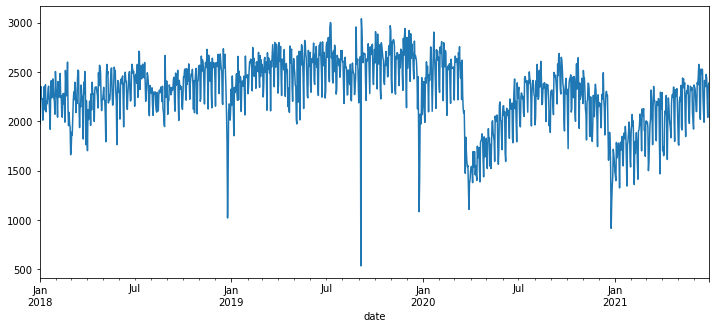

In [4]:
df['TNO Offs'].plot(figsize=(12,5))

In [5]:
df

,TNO Offs
date,
2018-01-01,2098.0
2018-01-02,1973.0
2018-01-03,2353.0
2018-01-04,2234.0
2018-01-05,2224.0
...,...
2021-06-26,2218.0
2021-06-27,2039.0
2021-06-28,2346.0


#Check For Stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)
  
  if dftest[0] < dftest[4]["5%"]:
      print ("Reject Ho - Time Series is Stationary")
  else:
      print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [7]:
adf_test(df['TNO Offs'])

1. ADF :  -2.8362085773289407
2. P-Value :  0.05328487148582228
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1255
5. Critical Values :
	 1% :  -3.435571295403709
	 5% :  -2.863845736356174
	 10% :  -2.567997600196822
Failed to Reject Ho - Time Series is Non-Stationary


#Figure Out Order for ARIMA Model

In [8]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
stepwise_fit = auto_arima(df['TNO Offs'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1277
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -8589.957
Date:                Fri, 03 Sep 2021   AIC                          17189.913
Time:                        02:29:35   BIC                          17215.671
Sample:                             0   HQIC                         17199.586
                               - 1277                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9051      0.094      9.673      0.000       0.722       1.088
ar.L2         -0.3818      0.037    -10.351      0.000      -0.454      -0.309
ma.L1         -1.4197      0.091    -15.567      0.000      -1.599      -1.241
ma.L2          0.5513      0.078      7.057      0.000       0.398       0.704
sigma2      4.115e+04    731.732     56.236      0.000    3.97e+04    4.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              7138.04
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.96
Prob(H) (two-sided):                  0.44   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from statsmodels.tsa.arima_model import ARIMA

#Split Data into Training and Testing

In [11]:
print(df.shape)
train=df.iloc[:-200]
test=df.iloc[-200:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1277, 1)
(1077, 1) (200, 1)
TNO Offs    1861.0
Name: 2020-12-13 00:00:00, dtype: float64 TNO Offs    2387.0
Name: 2021-06-30 00:00:00, dtype: float64


## Train the Model

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train['TNO Offs'],trend='c',order=(2,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               TNO Offs   No. Observations:                 1077
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7248.355
Date:                Fri, 03 Sep 2021   AIC                          14508.711
Time:                        02:29:36   BIC                          14538.597
Sample:                    01-01-2018   HQIC                         14520.029
                         - 12-12-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0260      0.897      0.029      0.977      -1.732       1.784
ar.L1          0.8783      0.125      7.013      0.000       0.633       1.124
ar.L2         -0.3287      0.044     -7.514      0.000      -0.414      -0.243
ma.L1         -1.4317      0.121    -11.875      0.000      -1.668      -1.195
ma.L2          0.5474      0.102      5.371      0.000       0.348       0.747
sigma2      4.151e+04    884.900     46.912      0.000    3.98e+04    4.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              7385.03
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.14
Prob(H) (two-sided):                  0.03   Kurtosis:                        15.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Make Predictions on Test Set

            TNO Offs
date                
2020-12-13    1861.0
2020-12-14    2150.0
2020-12-15    2278.0
2020-12-16    2303.0
2020-12-17    2259.0
...              ...
2021-06-26    2218.0
2021-06-27    2039.0
2021-06-28    2346.0
2021-06-29    2388.0
2021-06-30    2387.0

[200 rows x 1 columns]


<AxesSubplot:xlabel='date'>

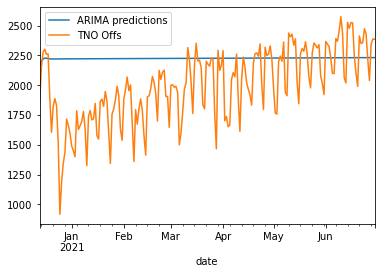

In [13]:
import matplotlib.pyplot as plt
start=len(train)
end=len(train)+len(test)-1
print(test)
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2020-12-13',end='2021-06-30')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test['TNO Offs'].plot(legend=True)

<AxesSubplot:xlabel='date'>

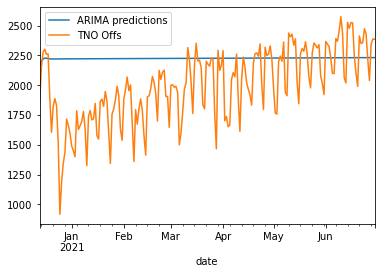

In [14]:
pred.plot(legend='ARIMA Predictions')
test['TNO Offs'].plot(legend=True)

In [15]:
test['TNO Offs'].mean()

1998.26

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['TNO Offs']))
print(rmse)
print(r2_score(test["TNO Offs"], pred))


378.5054617516526
-0.5433707162138712


In [17]:
model2=SARIMAX(df['TNO Offs'],trend='c',order=(2,1,2))
model2=model2.fit()
df.tail()

,TNO Offs
date,
2021-06-26,2218.0
2021-06-27,2039.0
2021-06-28,2346.0
2021-06-29,2388.0
2021-06-30,2387.0


In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['TNO Offs']))
print(rmse)
print(r2_score(test["TNO Offs"], pred))

378.5054617516526
-0.5433707162138712


#For Future Dates

In [19]:
index_future_dates=pd.date_range(start='2021-07-01',end='2021-07-31')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
# print(comp_pred)
pred.index=index_future_dates
print(pred)

2021-07-01    2335.876838
2021-07-02    2309.353328
2021-07-03    2304.930261
2021-07-04    2311.118247
2021-07-05    2318.472836
2021-07-06    2322.832431
2021-07-07    2324.036031
2021-07-08    2323.526640
2021-07-09    2322.671718
2021-07-10    2322.158016
2021-07-11    2322.085046
2021-07-12    2322.280700
2021-07-13    2322.551221
2021-07-14    2322.786953
2021-07-15    2322.962616
2021-07-16    2323.097196
2021-07-17    2323.217525
2021-07-18    2323.340639
2021-07-19    2323.471715
2021-07-20    2323.608933
2021-07-21    2323.748670
2021-07-22    2323.888344
2021-07-23    2324.026997
2021-07-24    2324.164751
2021-07-25    2324.302082
2021-07-26    2324.439372
2021-07-27    2324.576787
2021-07-28    2324.714331
2021-07-29    2324.851943
2021-07-30    2324.989569
2021-07-31    2325.127180
Freq: D, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

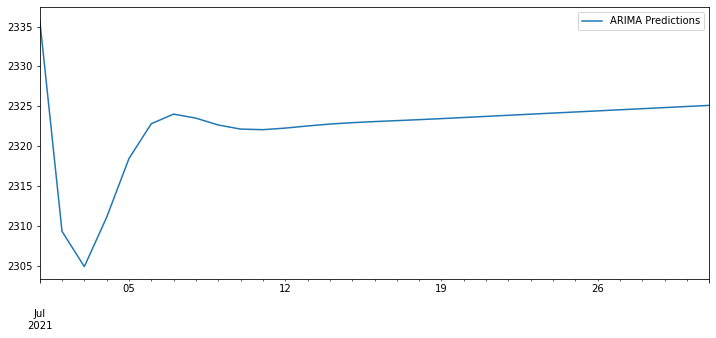

In [20]:
pred.plot(figsize=(12,5),legend=True)

<AxesSubplot:xlabel='date'>

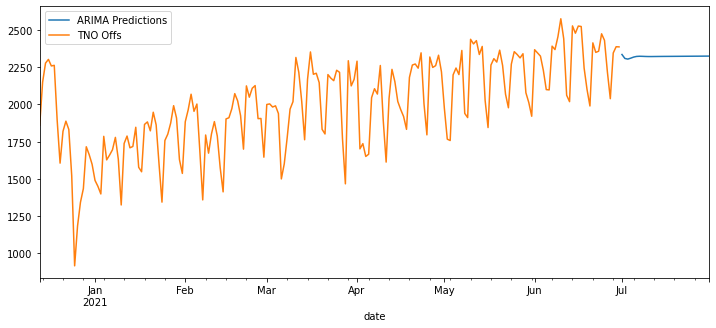

In [21]:
pred.plot(figsize=(12,5),legend=True)
test['TNO Offs'].plot(legend=True)